<h1>PTA Data Analysis with enterprise</h1>

This tutorial will walk you through the basics of running a gravitational wave search on pulsar timing array data using enterprise.

In [1]:
% matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import division

import numpy as np
import glob, os, json
import matplotlib.pyplot as plt
import corner

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

The first step is to load the data. Pulsar timing data is stored as par files, which contain a list of the pulsar's parameters and their uncertainties, and tim files, which contain the pulse times of arrival. Here we initialize all of the pulsar objects from the par and tim files (this will take a while).

In this tutorial, we will only analyze a single pulsar, J1713+0747.

In [2]:
datadir = 'data/'

In [3]:
parfiles = sorted(glob.glob(datadir + 'J1713*.par'))
timfiles = sorted(glob.glob(datadir + 'J1713*.tim'))

psrs = []
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    print 'Loading {0}'.format(psrname)
    psr = Pulsar(p, t, ephem='DE436')
    psrs.append(psr)

Loading J1713+0747


First, let's plot the residuals for this pulsar.

Number of TOAs: 27571


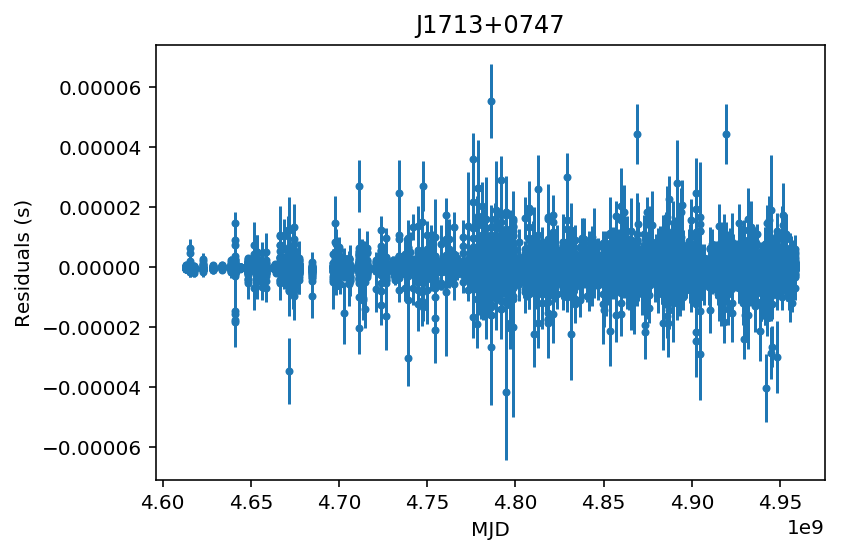

In [4]:
print 'Number of TOAs: {0}'.format(len(psrs[0].toas))

plt.errorbar(psrs[0].toas, psrs[0].residuals, ls='', marker='.', yerr=psrs[0].toaerrs)

plt.ylabel('Residuals (s)');
plt.xlabel('MJD');

plt.title(psrs[0].name);

First, let's add the white noise. There are three terms describing white noise: EFAC, which is a linear scaling of the TOA uncertainties; EQUAD, which is white noise added in quadrature to the TOA uncertainties; and ECORR, which is correlated over a single observation but uncorrelated between different observations.

In our analysis, we will fix the white noise to the maximum-likelihood values, which are found from noise analyses run on each pulsar. For now we will initialize the white noise parameters as constants. Later, we will read in the white noise values from a text file.

In [5]:
# white noise parameters
# here we define them as constants, later we will input the values after the model is initialized
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant()

# there will be separate white noise parameters for each observing backend
# since NANOGrav began taking data, there have been two generations of backends
# (ASP and PUPPI at Arecibo, GASP and GUPPI at Green Bank)
selection = selections.Selection(selections.by_backend)

# white noise signals
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = gp_signals.EcorrBasisModel(log10_ecorr=ecorr, selection=selection)

Now we add in the red noise. We model the red noise as a power law with two parameters: an amplitude and spectral index.

In [6]:
# red noise parameters
log10_A = parameter.Uniform(-18, -11)
gamma = parameter.Uniform(0, 7)

# define powerlaw PSD and red noise signal
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(pl, components=30, name='rn')

We also include contributions from the pulsar's timing model.

In [7]:
# linearized timing model
tm = gp_signals.TimingModel(use_svd=False)

Finally, we define the GW background. We model the background as a power law with fixed spectral index and an amplitude parameter. You can also do runs where you vary the spectral index and the amplitude simultaneously.

In [8]:
# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_Agw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_Agw, gamma=gamma_gw)
gwb = gp_signals.FourierBasisGP(spectrum=cpl, components=30, name='gwb')

Now we put together all of the signals to define the model.

In [9]:
# full signal
s = ef + eq + ec + rn + tm + gwb

Since we are only analzying a single pulsar, we will not include ephemeris modeling into the model. If you want to include it, set `bayesephem = True`.

In [10]:
# if you want to include ephemeris modeling, set bayesephem = True
bayesephem = False
if bayesephem:
    s += deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

Now we initalize the model and the PTA object.

In [11]:
# initialize PTA
model = [s(psr) for psr in psrs]
pta = signal_base.PTA(model)

We get the pulsars' white noise parameters from their noise files.

In [12]:
# load the white noise parameters from the noisefiles
noisedir = 'data/'
noisefiles = glob.glob(noisedir + '*.json')

setpars = {}
for nf in noisefiles:
    with open(nf, 'r') as fin:
        setpars.update(json.load(fin))

# fix the white noise parameters to the values in the noisefiles
pta.set_default_params(setpars)

INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_PUPPI_efac to 1.1139
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GASP_efac to 1.14264
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GUPPI_efac to 1.04
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_ASP_efac to 1.02291
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_ASP_efac to 1.11373
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_PUPPI_efac to 1.08988
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GUPPI_efac to 1.06397
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GASP_efac to 1.08451
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_ASP_log10_equad to -7.54974
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GUPPI_log10_equad to -7.14229
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_ASP_log10_equad to -7.91342
INFO: enterprise.signals.signal_base

Here we draw the initial values for the parameters.

This model only contains three parameters since we are only analyzing one pulsar, and we are not including `BayesEphem`. In general, if you run a gravitational wave search with fixed spectral index and without `BayesEphem`, you will have 2N + 1 parameters, where N is the number of pulsars in the PTA.

In [13]:
x0 = np.hstack(p.sample() for p in pta.params)
ndim = len(x0)

print ndim

3


In [14]:
pta.params

["J1713+0747_rn_gamma":Uniform(0,7),
 "J1713+0747_rn_log10_A":Uniform(-18,-11),
 "log10_A_gw":LinearExp(-18,-12)]

We need to set up a few other things before running the sampler. The sampler uses Adaptive Metropolis sampling, which uses the covariance matrix to determine the step sizes for the parameters. We initialize the covariance matrix as a diagonal matrix with the same value in each diagonal element. As the code runs, the covariance matrix will be updated based on the samples in the chain.

We also need to set up parameter groups, which determine which parameters should be jumped in simultaneously. For this run, we only have three groups: one containing all of the parameters, one containing both of the red noise parameters, and one containing the GWB amplitude.

In [15]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups 
ndim = len(x0)
groups  = [range(0, ndim)]
groups.extend(map(list, zip(range(0,ndim,2), range(1,ndim,2))))
groups.extend([[ndim-1]])
print groups

[[0, 1, 2], [0, 1], [2]]


Finally, we initialize the `sampler` object and sample!

In [16]:
outDir = 'chains/'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, 
                 outDir=outDir, resume=True)

In [17]:
# write a list of the parameters to a text file
# and a list of the parameter groupings used
filename = outDir + '/params.txt'
np.savetxt(filename,list(map(str, pta.param_names)), fmt='%s')
np.savetxt(outDir + 'groups.txt', groups, fmt='%s')

In [18]:
# sampler for N steps
# by default, the sampler saves every 10th step in the chain file
N = int(1e4)
x0 = np.hstack(p.sample() for p in pta.params)
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 90.00 percent in 527.202671 s Acceptance rate = 0.440889
Run Complete


Now that it has run for a while, let's take a look at the chains.

The chain contains the parameter values in the same order as in the `params.txt` file. The last four columns are the log-probability, the log-likelihood, the acceptance rate, and the parallel tempering acceptance rate (since we are not using parallel tempering, the last column will just be 1.)

In [19]:
chain = np.loadtxt('chains/chain_1.txt')
params = list(np.loadtxt('chains/params.txt', dtype='S42'))

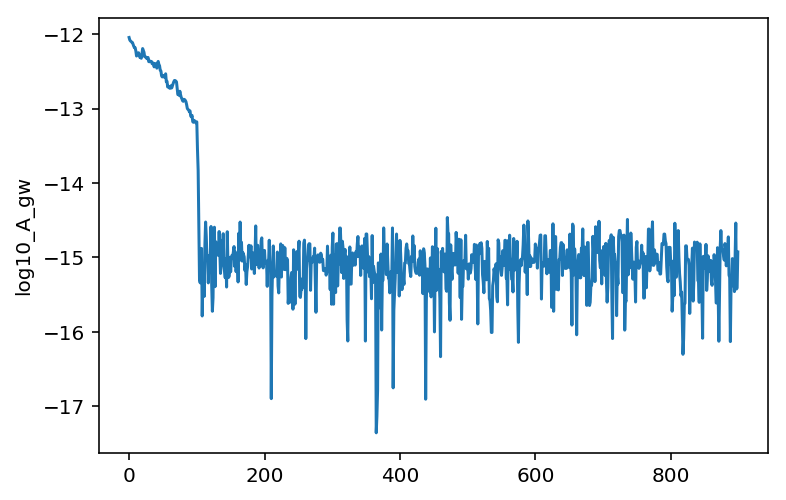

In [20]:
plt.plot(chain[:,params.index('log10_A_gw')]);
plt.ylabel('log10_A_gw');

We calculate the 95% upper limit on the GWB from this pulsar below. For comparison, the upper limit from the whole 11-year data set is $A_\mathrm{gw} < 1.45 \times 10^{-15}$.

2.0578807578986123e-15


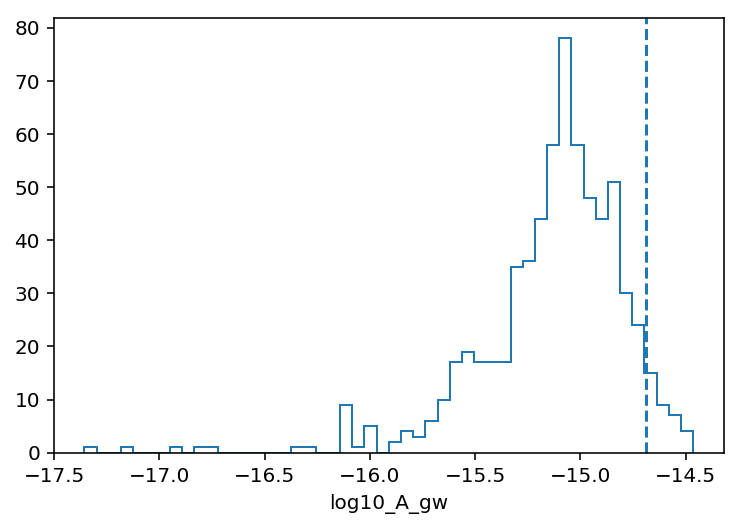

In [21]:
burn = int(0.25*chain.shape[0])

plt.hist(chain[burn:,params.index('log10_A_gw')], histtype='step', bins=50);
plt.xlabel('log10_A_gw');

ul = np.percentile(chain[burn:, params.index('log10_A_gw')], q=95)
plt.axvline(ul, ls='--')
print(10**ul)

Finally, let's take a look at the posteriors for all of the parameters in our model. You will notice that J1713+0747 does not have significant red noise.

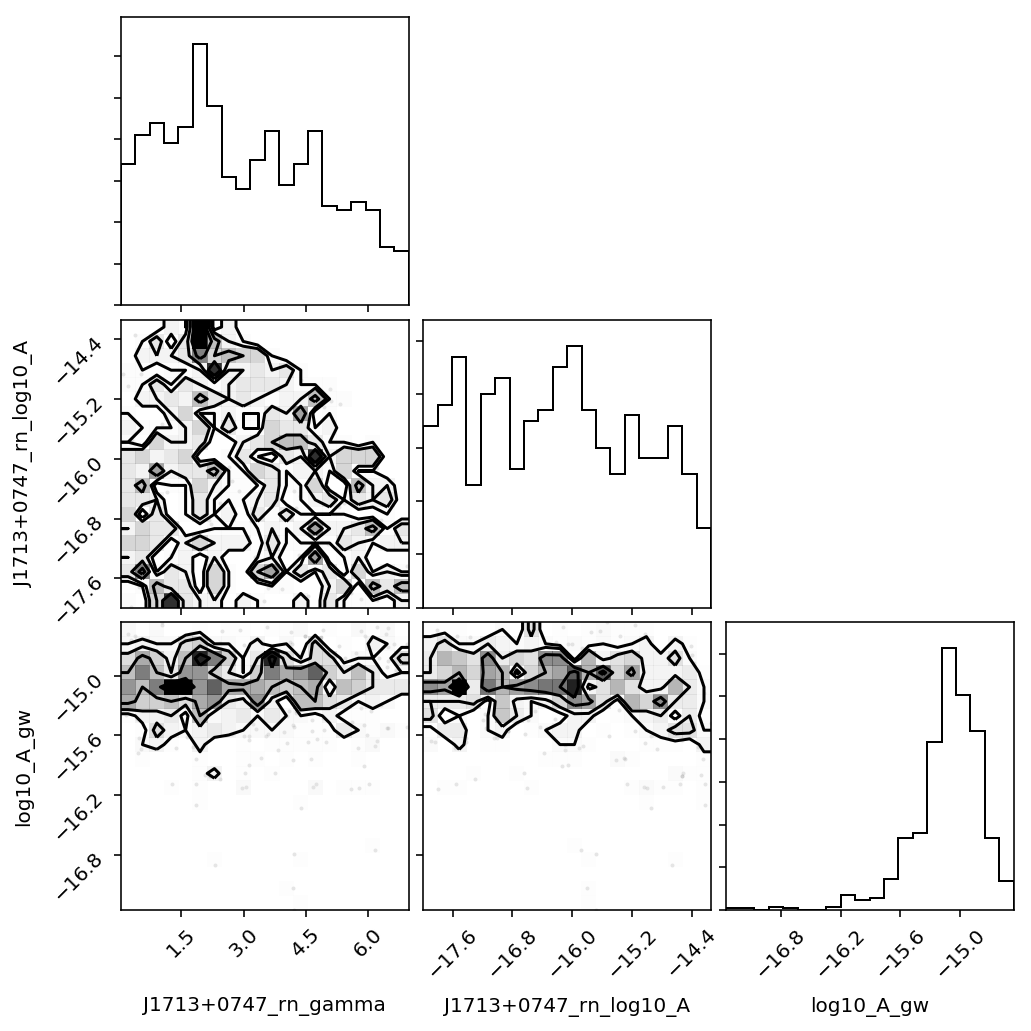

In [22]:
corner.corner(chain[burn:,:-4], labels=params);